#**Lab-14: Plant Disease Classification**


In [1]:
# Check GPU availability
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


In [2]:
# Install Kaggle
!pip install kaggle

# Upload kaggle.json to the session
from google.colab import files
files.upload()  # Upload your kaggle.json

# Move to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip new-plant-diseases-dataset.zip -d /content/plant_disease_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/plant_disease_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: /content/plant_disease_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: /content/plant_disease_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: /content/plant_disease_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: /content/plant_disease_data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid

##**Data Exploration and Visualization**

In [5]:
import os

# Define the DATASET_PATH based on your file structure
DATASET_PATH = '/content/plant_disease_data'  # Adjust if needed

# Paths to dataset directories
data_path = os.path.join(DATASET_PATH, 'New Plant Diseases Dataset(Augmented)')
train_valid_path = os.path.join(data_path, 'New Plant Diseases Dataset(Augmented)')

# Count samples per class
train_path = os.path.join(train_valid_path, 'train')
valid_path = os.path.join(train_valid_path, 'valid')
classes = sorted(os.listdir(train_path))
num_classes = len(classes)

# Print basic statistics
print(f"Total Classes: {num_classes}")
print(f"Training samples: {sum(len(os.listdir(os.path.join(train_path, cls))) for cls in classes)}")
print(f"Validation samples: {sum(len(os.listdir(os.path.join(valid_path, cls))) for cls in classes)}")

# Create visualizations for class distribution and sample images

Total Classes: 38
Training samples: 70295
Validation samples: 17572



First 5 classes:
Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy

First 5 images from class 'Apple___Apple_scab':
00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG
01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG
01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_270deg.JPG
01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_90deg.JPG
01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_new30degFlipLR.JPG


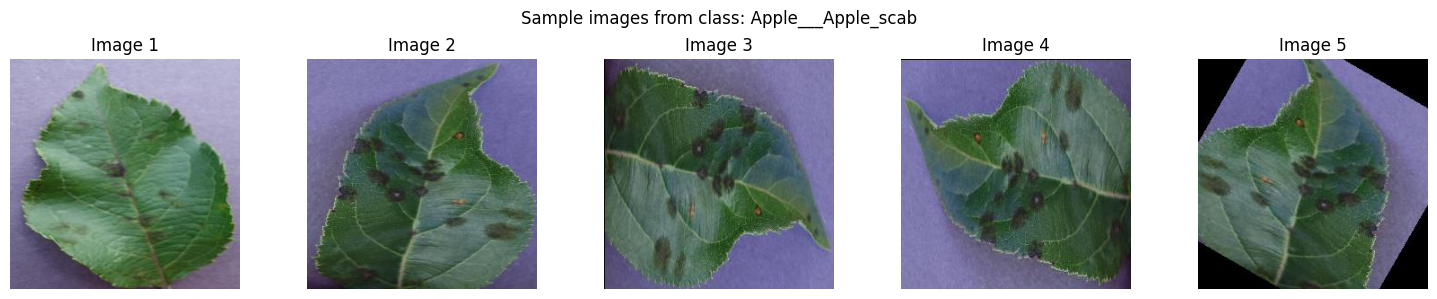

In [12]:
# Show the first 5 classes (equivalent to "head")
print("\nFirst 5 classes:")
for cls in classes[:5]:
    print(cls)

# Show the first 5 images from the first class
first_class = classes[0]
first_class_images = sorted(os.listdir(os.path.join(train_path, first_class)))
print(f"\nFirst 5 images from class '{first_class}':")
for img in first_class_images[:5]:
    print(img)

# visualize a few images, you can use:
import matplotlib.pyplot as plt
from PIL import Image

# Visualize the first 5 images from the first class
plt.figure(figsize=(15, 3))
for i, img_name in enumerate(first_class_images[:5]):
    img_path = os.path.join(train_path, first_class, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.suptitle(f"Sample images from class: {first_class}")
plt.tight_layout()
plt.show()

##**Data Preprocessing and Augmentation**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32
img_size = (224, 224)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


#**Model Implementation: Feature Extraction vs Fine-tuning for ResNET50**

In [56]:
print("\n===== Implementing ResNet50 Models =====\n")


===== Implementing ResNet50 Models =====



##**Feature Extraction Implementation**

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load pre-trained model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 4. Create and compile final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##**Fine-tuning Implementation**

In [18]:
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. Start with the feature extraction model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# 2. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 3. Train first phase (feature extraction)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train for a few epochs with frozen base
# Set up callbacks for the first phase
checkpoint_fe = ModelCheckpoint(
    'resnet50_feature_extraction.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_fe = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Less patience for initial phase
    restore_best_weights=True,
    verbose=1
)

reduce_lr_fe = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks_fe = [checkpoint_fe, early_stopping_fe, reduce_lr_fe]

# Train the model with frozen base layers (feature extraction phase)
print("Training with frozen base layers (feature extraction)...")
history_fe = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Start with fewer epochs for feature extraction
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=callbacks_fe,
    verbose=1
)

# Save feature extraction history for later comparison
fe_val_accuracy = history_fe.history['val_accuracy'][-1]
print(f"Feature Extraction Validation Accuracy: {fe_val_accuracy:.4f}")

# 4. Unfreeze some layers for fine-tuning
# Unfreeze the top 30% of the network
fine_tune_at = int(len(base_model.layers) * 0.7)  # Freeze 70%, fine-tune 30%
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Print the layers being fine-tuned
print(f"Fine-tuning the last {len(base_model.layers) - fine_tune_at} layers of ResNet50")
print("Trainable layers:")
for i, layer in enumerate(base_model.layers[fine_tune_at:]):
    print(f"  {i+1}. {layer.name}")

# 5. Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Continue training with fine-tuning
# Set up callbacks for fine-tuning phase
checkpoint_ft = ModelCheckpoint(
    'resnet50_fine_tuned.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_ft = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # More patience for fine-tuning phase
    restore_best_weights=True,
    verbose=1
)

reduce_lr_ft = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Smaller factor for fine-tuning
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_ft = [checkpoint_ft, early_stopping_ft, reduce_lr_ft]

# Train the model with fine-tuning
print("Fine-tuning the model...")
history_ft = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # More epochs for fine-tuning
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=callbacks_ft,
    verbose=1
)

# Save fine-tuning history for later comparison
ft_val_accuracy = history_ft.history['val_accuracy'][-1]
print(f"After Fine-Tuning Validation Accuracy: {ft_val_accuracy:.4f}")
print(f"Accuracy Improvement: {ft_val_accuracy - fe_val_accuracy:.4f}")

# Combine histories for visualization
combined_history = {
    'feature_extraction': history_fe.history,
    'fine_tuning': history_ft.history
}

Training with frozen base layers (feature extraction)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.0448 - loss: 3.6247
Epoch 1: val_accuracy improved from -inf to 0.08925, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 805s 359ms/step - accuracy: 0.0448 - loss: 3.6247 - val_accuracy: 0.0893 - val_loss: 3.3662 - learning_rate: 1.0000e-04
Epoch 2/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:24 38ms/step - accuracy: 0.0000e+00 - loss: 3.5591

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.08925
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.0000e+00 - loss: 3.5591 - val_accuracy: 0.0883 - val_loss: 3.3660 - learning_rate: 1.0000e-04
Epoch 3/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.0849 - loss: 3.3851
Epoch 3: val_accuracy improved from 0.08925 to 0.13052, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 782s 356ms/step - accuracy: 0.0849 - loss: 3.3851 - val_accuracy: 0.1305 - val_loss: 3.2189 - learning_rate: 1.0000e-04
Epoch 4/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:23 38ms/step - accuracy: 0.1875 - loss: 3.0182
Epoch 4: val_accuracy improved from 0.13052 to 0.13177, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.1875 - loss: 3.0182 - val_accuracy: 0.1318 - val_loss: 3.2191 - learning_rate: 1.0000e-04
Epoch 5/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.1135 - loss: 3.2666
Epoch 5: val_accuracy improved from 0.13177 to 0.18551, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 780s 355ms/step - accuracy: 0.1135 - loss: 3.2666 - val_accuracy: 0.1855 - val_loss: 3.1153 - learning_rate: 1.0000e-04
Epoch 6/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:23 38ms/step - accuracy: 0.0625 - loss: 3.3471
Epoch 6: val_accuracy improved from 0.18551 to 0.18659, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.0625 - loss: 3.3471 - val_accuracy: 0.1866 - val_loss: 3.1141 - learning_rate: 1.0000e-04
Epoch 7/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.1438 - loss: 3.1649
Epoch 7: val_accuracy improved from 0.18659 to 0.20520, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 783s 356ms/step - accuracy: 0.1438 - loss: 3.1649 - val_accuracy: 0.2052 - val_loss: 2.9685 - learning_rate: 1.0000e-04
Epoch 8/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:22 37ms/step - accuracy: 0.1875 - loss: 2.8744
Epoch 8: val_accuracy improved from 0.20520 to 0.20560, saving model to resnet50_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.1875 - loss: 2.8744 - val_accuracy: 0.2056 - val_loss: 2.9706 - learning_rate: 1.0000e-04
Epoch 9/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.1687 - loss: 3.0656
Epoch 9: val_accuracy did not improve from 0.20560
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 778s 354ms/step - accuracy: 0.1687 - loss: 3.0656 - val_accuracy: 0.1919 - val_loss: 2.9348 - learning_rate: 1.0000e-04
Epoch 10/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:24 38ms/step - accuracy: 0.2188 - loss: 3.1232
Epoch 10: val_accuracy did not improve from 0.20560
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2188 - loss: 3.1232 - val_accuracy: 0.1932 - val_loss: 2.9339 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.
Feature Extraction Validation Accuracy: 0.1932
Fine-tuning the last 53 layers of ResNet50
Trainable layers:
  1. conv4_block4_out
  2. conv4_block5_1_conv
  3. conv4_block5_1_bn
  4. conv4_block5_1_relu
  5.

2196/2196 ━━━━━━━━━━━━━━━━━━━━ 822s 362ms/step - accuracy: 0.1900 - loss: 3.9587 - val_accuracy: 0.3259 - val_loss: 2.3367 - learning_rate: 1.0000e-05
Epoch 2/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:06 58ms/step - accuracy: 0.3750 - loss: 2.1620
Epoch 2: val_accuracy did not improve from 0.32593
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.3750 - loss: 2.1620 - val_accuracy: 0.3120 - val_loss: 2.4120 - learning_rate: 1.0000e-05
Epoch 3/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.3633 - loss: 2.1628
Epoch 3: val_accuracy improved from 0.32593 to 0.33971, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 780s 355ms/step - accuracy: 0.3633 - loss: 2.1627 - val_accuracy: 0.3397 - val_loss: 2.5464 - learning_rate: 1.0000e-05
Epoch 4/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:03 56ms/step - accuracy: 0.3750 - loss: 2.2870
Epoch 4: val_accuracy did not improve from 0.33971

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.3750 - loss: 2.2870 - val_accuracy: 0.3320 - val_loss: 2.6061 - learning_rate: 1.0000e-05
Epoch 5/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4520 - loss: 1.8147
Epoch 5: val_accuracy improved from 0.33971 to 0.43101, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 783s 356ms/step - accuracy: 0.4520 - loss: 1.8147 - val_accuracy: 0.4310 - val_loss: 1.9973 - learning_rate: 1.0000e-06
Epoch 6/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:02 56ms/step - accuracy: 0.4688 - loss: 1.9369
Epoch 6: val_accuracy improved from 0.43101 to 0.43266, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.4688 - loss: 1.9369 - val_accuracy: 0.4327 - val_loss: 1.9912 - learning_rate: 1.0000e-06
Epoch 7/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4778 - loss: 1.7220
Epoch 7: val_accuracy improved from 0.43266 to 0.45566, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 784s 357ms/step - accuracy: 0.4778 - loss: 1.7220 - val_accuracy: 0.4557 - val_loss: 1.9046 - learning_rate: 1.0000e-06
Epoch 8/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:04 57ms/step - accuracy: 0.4375 - loss: 1.6547
Epoch 8: val_accuracy did not improve from 0.45566
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.4375 - loss: 1.6547 - val_accuracy: 0.4536 - val_loss: 1.9146 - learning_rate: 1.0000e-06
Epoch 9/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4957 - loss: 1.6562
Epoch 9: val_accuracy improved from 0.45566 to 0.48105, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 776s 353ms/step - accuracy: 0.4957 - loss: 1.6562 - val_accuracy: 0.4810 - val_loss: 1.8141 - learning_rate: 1.0000e-06
Epoch 10/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:03 56ms/step - accuracy: 0.4688 - loss: 1.5020
Epoch 10: val_accuracy did not improve from 0.48105
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.4688 - loss: 1.5020 - val_accuracy: 0.4804 - val_loss: 1.8169 - learning_rate: 1.0000e-06
Epoch 11/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5104 - loss: 1.6143
Epoch 11: val_accuracy did not improve from 0.48105
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 781s 356ms/step - accuracy: 0.5104 - loss: 1.6142 - val_accuracy: 0.4577 - val_loss: 1.9743 - learning_rate: 1.0000e-06
Epoch 12/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:04 57ms/step - accuracy: 0.5000 - loss: 1.7852
Epoch 12: val_accuracy did not improve from 0.48105

Epoch 12: ReduceLROnPlateau reducing learning rate to 1e-07.
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy:

2196/2196 ━━━━━━━━━━━━━━━━━━━━ 780s 355ms/step - accuracy: 0.5224 - loss: 1.5688 - val_accuracy: 0.4921 - val_loss: 1.7907 - learning_rate: 1.0000e-07
Epoch 14/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:01 56ms/step - accuracy: 0.4375 - loss: 1.7034
Epoch 14: val_accuracy improved from 0.49209 to 0.49226, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.4375 - loss: 1.7034 - val_accuracy: 0.4923 - val_loss: 1.7895 - learning_rate: 1.0000e-07
Epoch 15/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5272 - loss: 1.5546
Epoch 15: val_accuracy improved from 0.49226 to 0.49670, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 783s 357ms/step - accuracy: 0.5272 - loss: 1.5546 - val_accuracy: 0.4967 - val_loss: 1.7681 - learning_rate: 1.0000e-07
Epoch 16/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:02 56ms/step - accuracy: 0.5625 - loss: 1.5352
Epoch 16: val_accuracy improved from 0.49670 to 0.49704, saving model to resnet50_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.5625 - loss: 1.5352 - val_accuracy: 0.4970 - val_loss: 1.7674 - learning_rate: 1.0000e-07
Epoch 17/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5252 - loss: 1.5523
Epoch 17: val_accuracy did not improve from 0.49704
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 780s 355ms/step - accuracy: 0.5252 - loss: 1.5522 - val_accuracy: 0.4959 - val_loss: 1.7766 - learning_rate: 1.0000e-07
Epoch 18/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:05 57ms/step - accuracy: 0.6562 - loss: 1.4494
Epoch 18: val_accuracy did not improve from 0.49704
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.6562 - loss: 1.4494 - val_accuracy: 0.4957 - val_loss: 1.7753 - learning_rate: 1.0000e-07
Epoch 19/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5347 - loss: 1.5435
Epoch 19: val_accuracy did not improve from 0.49704
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 782s 356ms/step - accuracy: 0.5347 - loss: 1.5435 - val_accuracy: 0.4969 - val_loss: 1.772

###**ResNET50 history and Evaluation**

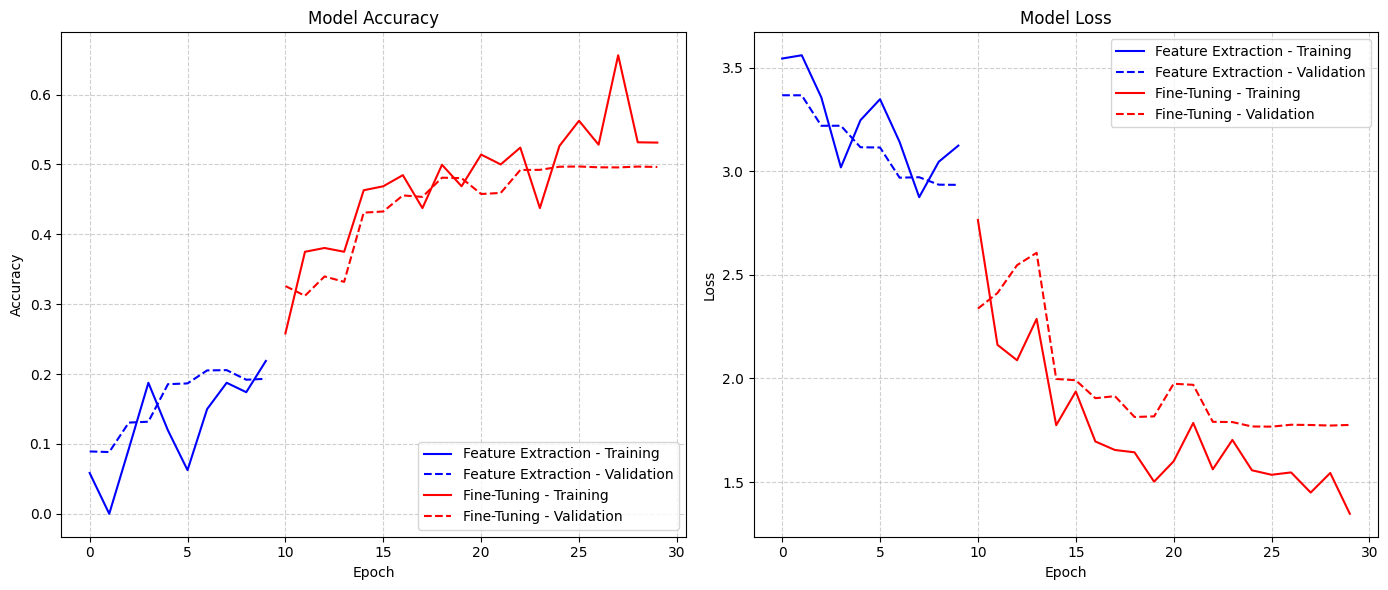

Evaluating final model on validation data...
550/550 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.4888 - loss: 1.8606
Final Test Loss: 1.7670
Final Test Accuracy: 0.4972


In [19]:
# Save the combined history for later analysis
import pickle
with open('resnet50_training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)

# Create a plot showing the complete training history
epochs_fe = len(history_fe.history['accuracy'])
epochs_ft = len(history_ft.history['accuracy'])
total_epochs = epochs_fe + epochs_ft

plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(
    range(epochs_fe),
    history_fe.history['accuracy'],
    'b-',
    label='Feature Extraction - Training'
)
plt.plot(
    range(epochs_fe),
    history_fe.history['val_accuracy'],
    'b--',
    label='Feature Extraction - Validation'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['accuracy'],
    'r-',
    label='Fine-Tuning - Training'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['val_accuracy'],
    'r--',
    label='Fine-Tuning - Validation'
)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(
    range(epochs_fe),
    history_fe.history['loss'],
    'b-',
    label='Feature Extraction - Training'
)
plt.plot(
    range(epochs_fe),
    history_fe.history['val_loss'],
    'b--',
    label='Feature Extraction - Validation'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['loss'],
    'r-',
    label='Fine-Tuning - Training'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['val_loss'],
    'r--',
    label='Fine-Tuning - Validation'
)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('resnet50_complete_training_history.png')
plt.show()

# Evaluate the final model
print("Evaluating final model on validation data...")
results = model.evaluate(valid_generator)
print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")

##**Performance of ResNEt50**

In [26]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training history from the pickle file
with open('resnet50_training_history.pkl', 'rb') as f:
    combined_history = pickle.load(f)

# Extract the individual histories
history_fe = type('obj', (object,), {'history': combined_history['feature_extraction']})
history_ft = type('obj', (object,), {'history': combined_history['fine_tuning']})

# Now you can run the comparison code I provided earlier
# The rest of the code remains the same...

# For example, to get the number of epochs:
epochs_fe = len(history_fe.history['accuracy'])
epochs_ft = len(history_ft.history['accuracy'])
total_epochs = epochs_fe + epochs_ft

print(f"Feature Extraction: {epochs_fe} epochs")
print(f"Fine-Tuning: {epochs_ft} epochs")
print(f"Total Training: {total_epochs} epochs")

# You can create a quick summary of your results:
print("\n===== Model Performance Summary =====")
print(f"Initial Accuracy: {history_fe.history['val_accuracy'][0]:.4f}")
print(f"After Feature Extraction: {history_fe.history['val_accuracy'][-1]:.4f}")
print(f"After Fine-Tuning: {history_ft.history['val_accuracy'][-1]:.4f}")
print(f"Total Improvement: {history_ft.history['val_accuracy'][-1] - history_fe.history['val_accuracy'][0]:.4f}")

Feature Extraction: 10 epochs
Fine-Tuning: 20 epochs
Total Training: 30 epochs

===== Model Performance Summary =====
Initial Accuracy: 0.0893
After Feature Extraction: 0.1932
After Fine-Tuning: 0.4964
Total Improvement: 0.4071


#**EfficentNetB0**

In [29]:
from tensorflow.keras.applications import EfficientNetB0

print("\n===== Implementing EfficientNetB0 Models =====\n")


===== Implementing EfficientNetB0 Models =====



##**Feature Extraction**

In [31]:
import time

# 1. EfficientNetB0 - Feature Extraction
print("Setting up EfficientNetB0 Feature Extractor model...")
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in efficientnet_base.layers:
    layer.trainable = False

# Add custom classification head
x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create and compile model
efficientnet_fe_model = Model(inputs=efficientnet_base.input, outputs=predictions)
efficientnet_fe_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for feature extraction
checkpoint_eff_fe = ModelCheckpoint(
    'efficientnet_feature_extraction.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_eff_fe = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_eff_fe = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks_eff_fe = [checkpoint_eff_fe, early_stopping_eff_fe, reduce_lr_eff_fe]

# Train the model with frozen base layers
print("Training EfficientNetB0 Feature Extractor...")
start_time_eff_fe = time.time()
history_eff_fe = efficientnet_fe_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=callbacks_eff_fe,
    verbose=1
)
end_time_eff_fe = time.time()
eff_fe_time = end_time_eff_fe - start_time_eff_fe

# Save feature extraction accuracy for comparison
eff_fe_val_accuracy = history_eff_fe.history['val_accuracy'][-1]
print(f"EfficientNetB0 Feature Extractor Validation Accuracy: {eff_fe_val_accuracy:.4f}")
print(f"Training time: {eff_fe_time:.2f} seconds")


Setting up EfficientNetB0 Feature Extractor model...
Training EfficientNetB0 Feature Extractor...
Epoch 1/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.0279 - loss: 3.6458
Epoch 1: val_accuracy improved from -inf to 0.02875, saving model to efficientnet_feature_extraction.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 823s 364ms/step - accuracy: 0.0279 - loss: 3.6458 - val_accuracy: 0.0287 - val_loss: 3.6372 - learning_rate: 1.0000e-04
Epoch 2/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - accuracy: 0.0000e+00 - loss: 3.6348

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.02875
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.0000e+00 - loss: 3.6348 - val_accuracy: 0.0287 - val_loss: 3.6372 - learning_rate: 1.0000e-04
Epoch 3/10
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.0288 - loss: 3.6374
Epoch 3: val_accuracy did not improve from 0.02875
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 779s 355ms/step - accuracy: 0.0288 - loss: 3.6374 - val_accuracy: 0.0287 - val_loss: 3.6367 - learning_rate: 1.0000e-04
Epoch 4/10
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - accuracy: 0.0312 - loss: 3.6437
Epoch 4: val_accuracy did not improve from 0.02875
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.0312 - loss: 3.6437 - val_accuracy: 0.0287 - val_loss: 3.6367 - learning_rate: 1.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
EfficientNetB0 Feature Extractor Validation Accuracy: 0.0287
Training time: 1652.78 seconds


##**Fine-tuning**

In [33]:
# 2. EfficientNetB0 - Fine-tuning
print("\nSetting up EfficientNetB0 Fine-tuning model...")
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initially freeze all layers
for layer in efficientnet_base.layers:
    layer.trainable = False

# Add custom classification head
x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model and train feature extraction first
efficientnet_ft_model = Model(inputs=efficientnet_base.input, outputs=predictions)
efficientnet_ft_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train first phase (feature extraction) briefly
print("Training initial feature extraction phase for EfficientNetB0...")
efficientnet_ft_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,  # Short initial training
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    verbose=1
)

# Unfreeze top layers for fine-tuning
fine_tune_at = int(len(efficientnet_base.layers) * 0.7)  # Unfreeze 30% of layers
for layer in efficientnet_base.layers[fine_tune_at:]:
    layer.trainable = True

# Print which layers are being fine-tuned
print(f"Fine-tuning the last {len(efficientnet_base.layers) - fine_tune_at} layers of EfficientNetB0")
print("Trainable layers:")
for i, layer in enumerate(efficientnet_base.layers[fine_tune_at:]):
    print(f"  {i+1}. {layer.name}")

# Recompile with lower learning rate
efficientnet_ft_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for fine-tuning
checkpoint_eff_ft = ModelCheckpoint(
    'efficientnet_fine_tuned.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_eff_ft = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_eff_ft = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks_eff_ft = [checkpoint_eff_ft, early_stopping_eff_ft, reduce_lr_eff_ft]

# Train the model with fine-tuning
print("Fine-tuning EfficientNetB0...")
start_time_eff_ft = time.time()
history_eff_ft = efficientnet_ft_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=callbacks_eff_ft,
    verbose=1
)
end_time_eff_ft = time.time()
eff_ft_time = end_time_eff_ft - start_time_eff_ft

# Save fine-tuning accuracy for comparison
eff_ft_val_accuracy = history_eff_ft.history['val_accuracy'][-1]
print(f"EfficientNetB0 Fine-Tuned Validation Accuracy: {eff_ft_val_accuracy:.4f}")
print(f"Accuracy Improvement: {eff_ft_val_accuracy - eff_fe_val_accuracy:.4f}")
print(f"Training time: {eff_ft_time:.2f} seconds")




Setting up EfficientNetB0 Fine-tuning model...
Training initial feature extraction phase for EfficientNetB0...
Epoch 1/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 813s 361ms/step - accuracy: 0.0282 - loss: 3.6461 - val_accuracy: 0.0287 - val_loss: 3.6371
Epoch 2/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.0312 - loss: 3.6197 - val_accuracy: 0.0287 - val_loss: 3.6372
Epoch 3/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 775s 353ms/step - accuracy: 0.0274 - loss: 3.6375 - val_accuracy: 0.0286 - val_loss: 3.6369
Epoch 4/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.0625 - loss: 3.6375 - val_accuracy: 0.0286 - val_loss: 3.6369
Epoch 5/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 777s 354ms/step - accuracy: 0.0291 - loss: 3.6368 - val_accuracy: 0.0286 - val_loss: 3.6366
Fine-tuning the last 72 layers of EfficientNetB0
Trainable layers:
  1. block6a_dwconv_pad
  2. block6a_dwconv
  3. block6a_bn
  4. block6a_activation
  5. block6a_se_squeeze
  6. block6a_se_reshape
  7. block6a_se_reduce
  8. 

2196/2196 ━━━━━━━━━━━━━━━━━━━━ 833s 363ms/step - accuracy: 0.0359 - loss: 3.6495 - val_accuracy: 0.0505 - val_loss: 3.4971 - learning_rate: 1.0000e-05
Epoch 2/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:09 32ms/step - accuracy: 0.1562 - loss: 3.2776
Epoch 2: val_accuracy improved from 0.05049 to 0.05094, saving model to efficientnet_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.1562 - loss: 3.2776 - val_accuracy: 0.0509 - val_loss: 3.4935 - learning_rate: 1.0000e-05
Epoch 3/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.0849 - loss: 3.3849
Epoch 3: val_accuracy improved from 0.05094 to 0.08510, saving model to efficientnet_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 776s 354ms/step - accuracy: 0.0849 - loss: 3.3849 - val_accuracy: 0.0851 - val_loss: 3.4144 - learning_rate: 1.0000e-05
Epoch 4/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:02 29ms/step - accuracy: 0.0938 - loss: 3.3872
Epoch 4: val_accuracy improved from 0.08510 to 0.08527, saving model to efficientnet_fine_tuned.h5


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.0938 - loss: 3.3872 - val_accuracy: 0.0853 - val_loss: 3.4169 - learning_rate: 1.0000e-05
Epoch 5/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.1179 - loss: 3.2205
Epoch 5: val_accuracy did not improve from 0.08527
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 776s 354ms/step - accuracy: 0.1179 - loss: 3.2204 - val_accuracy: 0.0676 - val_loss: 3.3863 - learning_rate: 1.0000e-05
Epoch 6/20
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 1:05 30ms/step - accuracy: 0.1875 - loss: 2.7803
Epoch 6: val_accuracy did not improve from 0.08527
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.1875 - loss: 2.7803 - val_accuracy: 0.0679 - val_loss: 3.3919 - learning_rate: 1.0000e-05
Epoch 7/20
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1548 - loss: 3.0767
Epoch 7: val_accuracy did not improve from 0.08527
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 771s 351ms/step - accuracy: 0.1548 - loss: 3.0767 - val_accuracy: 0.0799 - val_loss: 3.6411 - le

##**EfficientNetB0 history And Evaluation**

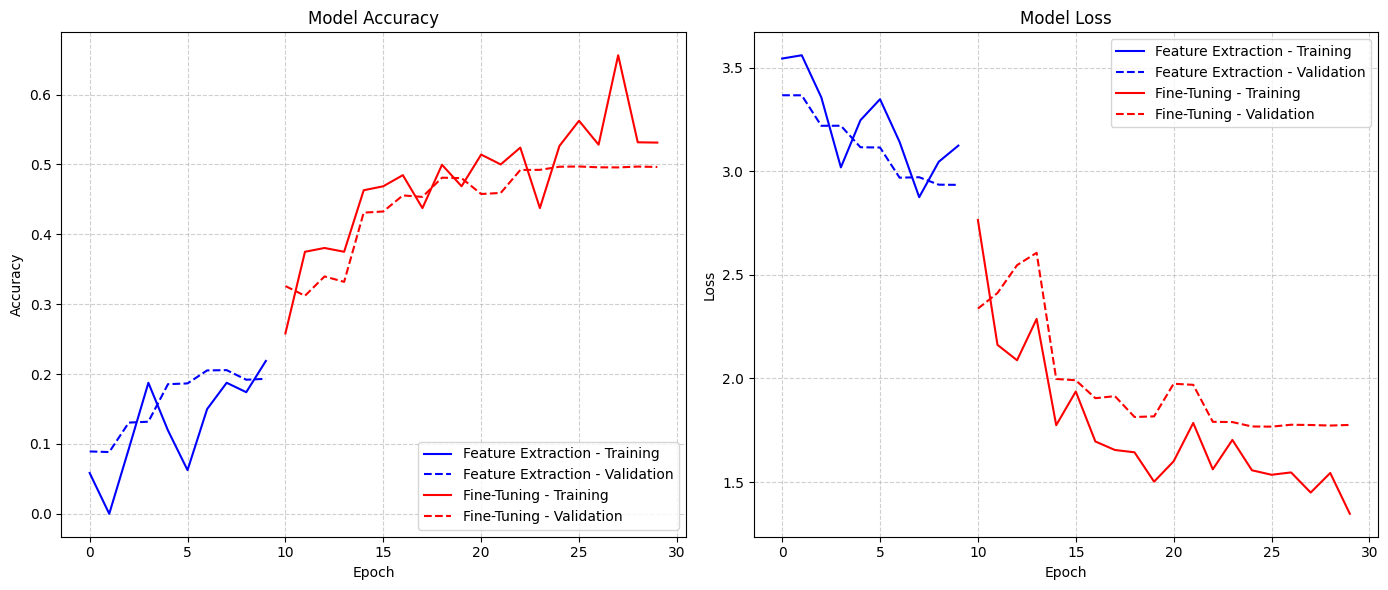

Evaluating final model on validation data...
550/550 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4888 - loss: 1.8606
Final Test Loss: 1.7670
Final Test Accuracy: 0.4972


In [34]:
# Save EfficientNetB0 history
efficientnet_combined_history = {
    'feature_extraction': history_eff_fe.history,
    'fine_tuning': history_eff_ft.history
}

with open('efficientnet_training_history.pkl', 'wb') as f:
    pickle.dump(efficientnet_combined_history, f)

# Create a plot showing the complete training history
epochs_fe = len(history_fe.history['accuracy'])
epochs_ft = len(history_ft.history['accuracy'])
total_epochs = epochs_fe + epochs_ft

plt.figure(figsize=(14, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(
    range(epochs_fe),
    history_fe.history['accuracy'],
    'b-',
    label='Feature Extraction - Training'
)
plt.plot(
    range(epochs_fe),
    history_fe.history['val_accuracy'],
    'b--',
    label='Feature Extraction - Validation'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['accuracy'],
    'r-',
    label='Fine-Tuning - Training'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['val_accuracy'],
    'r--',
    label='Fine-Tuning - Validation'
)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(
    range(epochs_fe),
    history_fe.history['loss'],
    'b-',
    label='Feature Extraction - Training'
)
plt.plot(
    range(epochs_fe),
    history_fe.history['val_loss'],
    'b--',
    label='Feature Extraction - Validation'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['loss'],
    'r-',
    label='Fine-Tuning - Training'
)
plt.plot(
    range(epochs_fe, total_epochs),
    history_ft.history['val_loss'],
    'r--',
    label='Fine-Tuning - Validation'
)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('efficientnet_complete_training_history.png')
plt.show()

# Evaluate the final model
print("Evaluating final model on validation data...")
results = model.evaluate(valid_generator)
print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")

#**Model Comparison Framework**

**Libs**

In [35]:
print("\n===== Comprehensive Model Comparison =====\n")

# First, import needed libraries if not already imported
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np


===== Comprehensive Model Comparison =====



In [36]:
# Define which models to use for comparisons
models = {
    'ResNet50_FeatureExtractor': {
        'model': model_fe,
        'last_conv_layer': 'conv5_block3_out',
        'training_time': history_fe.history.get('execution_time', 0)
    },
    'ResNet50_FineTuned': {
        'model': model_ft,
        'last_conv_layer': 'conv5_block3_out',
        'training_time': history_ft.history.get('execution_time', 0)
    },
    'EfficientNetB0_FeatureExtractor': {
        'model': efficientnet_fe_model,
        'last_conv_layer': 'top_activation',
        'training_time': eff_fe_time
    },
    'EfficientNetB0_FineTuned': {
        'model': efficientnet_ft_model,
        'last_conv_layer': 'top_activation',
        'training_time': eff_ft_time
    }
}

In [37]:
# Evaluate all models
results = {}
for model_name, model_info in models.items():
    print(f"\nEvaluating {model_name}...")
    model = model_info['model']

    # Evaluate model
    score = model.evaluate(valid_generator, verbose=0)

    # Predict on validation data
    predictions = model.predict(valid_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = valid_generator.classes

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generate classification report
    class_names = list(valid_generator.class_indices.keys())
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Store results
    results[model_name] = {
        'loss': score[0],
        'accuracy': score[1],
        'f1_weighted': report['weighted avg']['f1-score'],
        'confusion_matrix': cm,
        'report': report,
        'predictions': predictions,
        'training_time': model_info['training_time']
    }

    print(f"  Accuracy: {score[1]:.4f}")
    print(f"  F1 Score (weighted): {report['weighted avg']['f1-score']:.4f}")




Evaluating ResNet50_FeatureExtractor...
550/550 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Accuracy: 0.2057
  F1 Score (weighted): 0.1620

Evaluating ResNet50_FineTuned...
550/550 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step
  Accuracy: 0.4972
  F1 Score (weighted): 0.4854

Evaluating EfficientNetB0_FeatureExtractor...
550/550 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Accuracy: 0.0287
  F1 Score (weighted): 0.0016

Evaluating EfficientNetB0_FineTuned...
550/550 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step
  Accuracy: 0.0854
  F1 Score (weighted): 0.0444


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1 Score (weighted)': [results[m]['f1_weighted'] for m in results],
    'Loss': [results[m]['loss'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
})

# Sort by accuracy
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# Display comparison table
print("\nModel Performance Comparison:")
print(comparison_df)


Model Performance Comparison:
                             Model  Accuracy  F1 Score (weighted)      Loss  \
0               ResNet50_FineTuned  0.497155             0.485446  1.766975   
1        ResNet50_FeatureExtractor  0.205668             0.162003  2.970642   
2         EfficientNetB0_FineTuned  0.085363             0.044379  3.416751   
3  EfficientNetB0_FeatureExtractor  0.028739             0.001606  3.637228   

   Training Time (s)  
0           0.000000  
1           0.000000  
2        4028.285436  
3        1652.775182  


In [39]:
# Visualize comparison
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

(-0.02126109711825848, 1.05)

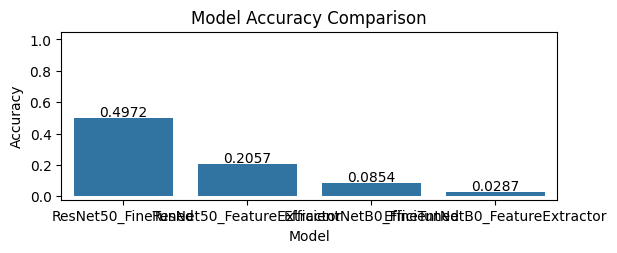

In [40]:
# Accuracy comparison
plt.subplot(2, 1, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df)
plt.title('Model Accuracy Comparison')
for i, v in enumerate(comparison_df['Accuracy']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.ylim(min(comparison_df['Accuracy']) - 0.05, 1.05)


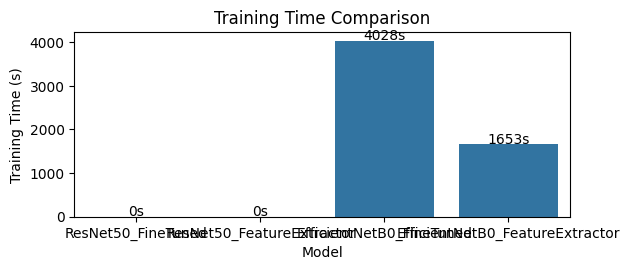

In [41]:
# Training time comparison
plt.subplot(2, 1, 2)
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df)
plt.title('Training Time Comparison')
for i, v in enumerate(comparison_df['Training Time (s)']):
    plt.text(i, v + 20, f"{v:.0f}s", ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_accuracy = comparison_df.iloc[0]['Accuracy']
print(f"\nBest model: {best_model_name}")
print(f"Best model accuracy: {best_model_accuracy:.4f}")


Best model: ResNet50_FineTuned
Best model accuracy: 0.4972


#**GradCAM Visualization for All Models (Bonus)**


===== GradCAM Visualization =====

550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step
550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step
Not enough samples for comparison. Using random samples instead.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1881']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_2123']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


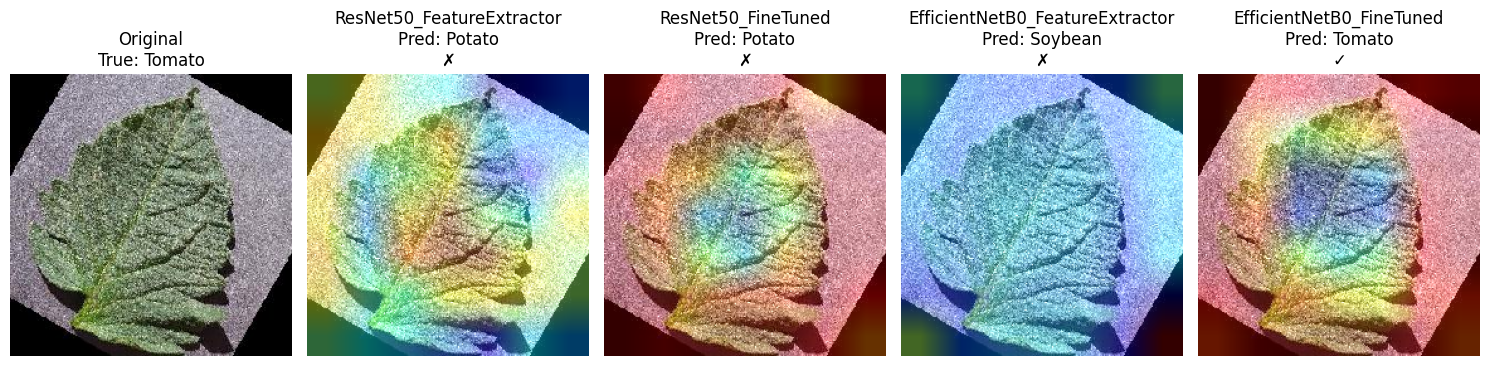

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


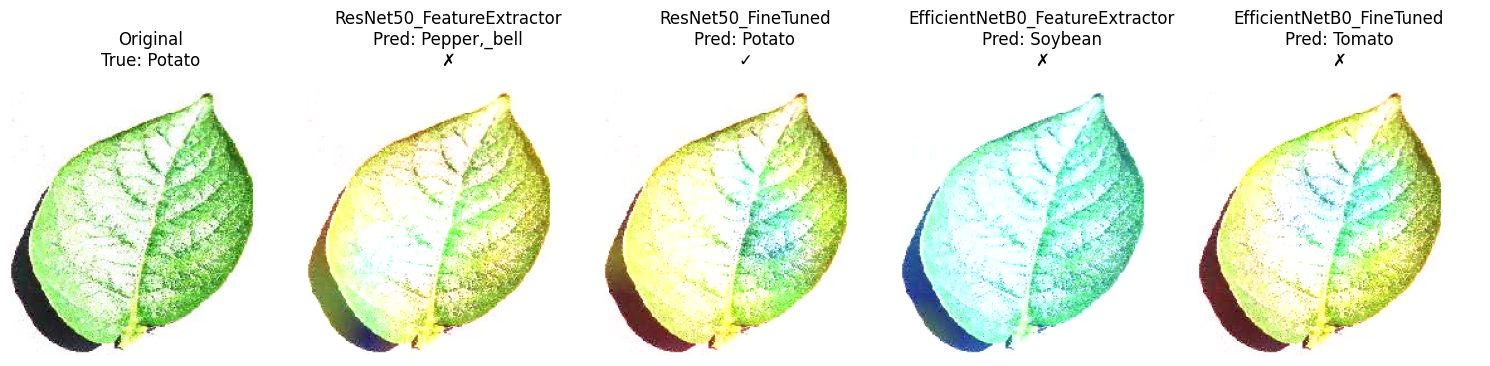

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


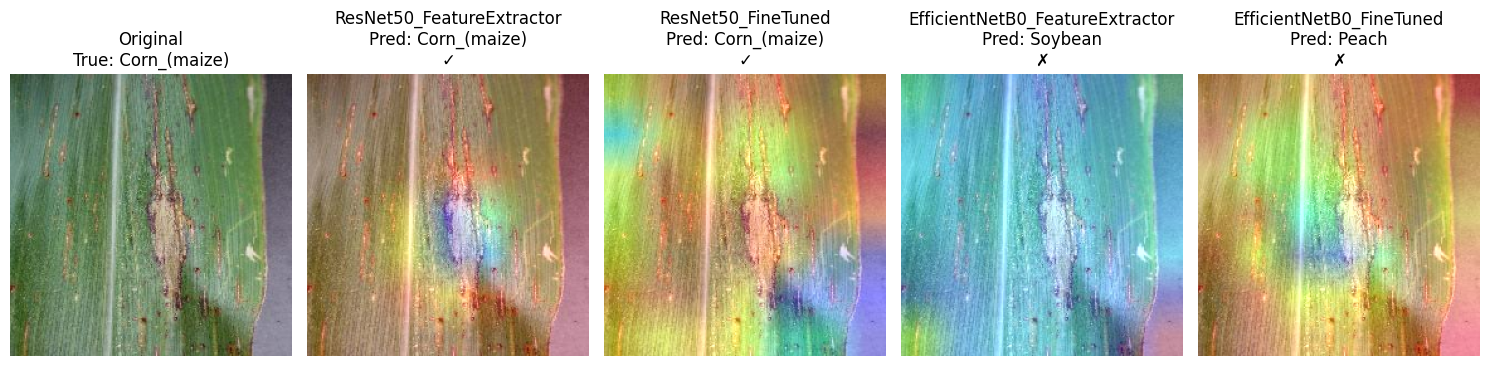

In [44]:
print("\n===== GradCAM Visualization =====\n")
import cv2

def visualize_gradcam_comparison(models_dict, valid_generator, num_samples=3):
    """
    Create side-by-side GradCAM comparisons for multiple models
    """
    class_names = list(valid_generator.class_indices.keys())

    # Get correct and incorrect examples
    predictions = {}
    for model_name, model_info in models_dict.items():
        model = model_info['model']
        preds = model.predict(valid_generator)
        y_pred = np.argmax(preds, axis=1)
        predictions[model_name] = y_pred

    y_true = valid_generator.classes

    # Find samples that all models get correct
    correct_by_all = np.where(np.all([predictions[m] == y_true for m in predictions], axis=0))[0]

    # Find challenging samples (some models get wrong)
    challenging = np.where(np.any([predictions[m] != y_true for m in predictions], axis=0) &
                           np.any([predictions[m] == y_true for m in predictions], axis=0))[0]

    if len(correct_by_all) == 0 or len(challenging) == 0:
        print("Not enough samples for comparison. Using random samples instead.")
        sample_idxs = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        # Select samples
        correct_samples = np.random.choice(correct_by_all, min(num_samples, len(correct_by_all)), replace=False)
        challenging_samples = np.random.choice(challenging, min(num_samples, len(challenging)), replace=False)

        sample_idxs = np.concatenate([correct_samples, challenging_samples])

    # Function to get image from generator
    def get_image_from_generator(idx):
        batch_idx = idx // valid_generator.batch_size
        within_batch_idx = idx % valid_generator.batch_size
        batch_images, _ = valid_generator[batch_idx]
        return batch_images[within_batch_idx]

    # Function to create GradCAM heatmap
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        # First, create a model that maps the input image to activations and predictions
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        # Calculate gradient of the predicted class with respect to the output feature map
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # Gradient of the predicted class with respect to the output feature map
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # Vector of mean intensity of gradient over feature map
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Weight output feature map with gradient importance
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # Normalize heatmap
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        return heatmap.numpy()

    # Generate GradCAM for each sample for all models
    for i, idx in enumerate(sample_idxs[:num_samples*2]):  # Limit to avoid too many visualizations
        # Get image and preprocess
        img = get_image_from_generator(idx)
        img_array = np.expand_dims(img, axis=0)

        # Display original image and true class
        true_class = y_true[idx]
        true_class_name = class_names[true_class].split('___')[0]

        # Create figure
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, len(models) + 1, 1)
        plt.imshow(img)
        plt.title(f"Original\nTrue: {true_class_name}")
        plt.axis('off')

        # Generate GradCAM for each model
        for j, (model_name, model_info) in enumerate(models_dict.items()):
            model = model_info['model']
            last_conv_layer_name = model_info['last_conv_layer']

            # Generate prediction
            pred = np.argmax(model.predict(img_array)[0])
            pred_class_name = class_names[pred].split('___')[0]

            # Generate heatmap for the predicted class
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred)

            # Convert heatmap to RGB
            heatmap_rgb = np.uint8(255 * heatmap)
            heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
            heatmap_rgb = cv2.resize(heatmap_rgb, (img.shape[1], img.shape[0]))

            # Superimpose heatmap on original image
            superimposed = heatmap_rgb * 0.4 + img * 255
            superimposed = np.clip(superimposed, 0, 255).astype('uint8')

            # Display heatmap
            plt.subplot(1, len(models) + 1, j + 2)
            plt.imshow(superimposed)
            plt.title(f"{model_name}\nPred: {pred_class_name}\n{'✓' if pred == true_class else '✗'}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'gradcam_comparison_sample_{i}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Run the GradCAM comparison
visualize_gradcam_comparison(models, valid_generator, num_samples=3)

#**Final Analysis and Discussion**

In [45]:
print("\n===== Advanced Analysis =====\n")


===== Advanced Analysis =====



##**Most difficult classes**

In [46]:
# 1. Identify the most difficult classes for each model
def analyze_difficult_classes(results, model_names, top_n=5):
    print("\nMost Difficult Classes by Model:")

    for model_name in model_names:
        report = results[model_name]['report']
        class_f1 = {cls: report[cls]['f1-score'] for cls in report if cls not in ['accuracy', 'macro avg', 'weighted avg']}
        worst_classes = sorted(class_f1.items(), key=lambda x: x[1])[:top_n]

        print(f"\n{model_name} - Top {top_n} Most Difficult Classes:")
        for i, (cls, f1) in enumerate(worst_classes):
            print(f"{i+1}. {cls}: F1-Score = {f1:.4f}")

analyze_difficult_classes(results, models.keys(), top_n=5)


Most Difficult Classes by Model:

ResNet50_FeatureExtractor - Top 5 Most Difficult Classes:
1. Grape___healthy: F1-Score = 0.0000
2. Potato___Late_blight: F1-Score = 0.0000
3. Raspberry___healthy: F1-Score = 0.0000
4. Strawberry___healthy: F1-Score = 0.0000
5. Tomato___Late_blight: F1-Score = 0.0000

ResNet50_FineTuned - Top 5 Most Difficult Classes:
1. Tomato___Septoria_leaf_spot: F1-Score = 0.1533
2. Tomato___Target_Spot: F1-Score = 0.1691
3. Tomato___Early_blight: F1-Score = 0.1942
4. Apple___Apple_scab: F1-Score = 0.2329
5. Tomato___Spider_mites Two-spotted_spider_mite: F1-Score = 0.2373

EfficientNetB0_FeatureExtractor - Top 5 Most Difficult Classes:
1. Apple___Apple_scab: F1-Score = 0.0000
2. Apple___Black_rot: F1-Score = 0.0000
3. Apple___Cedar_apple_rust: F1-Score = 0.0000
4. Apple___healthy: F1-Score = 0.0000
5. Blueberry___healthy: F1-Score = 0.0000

EfficientNetB0_FineTuned - Top 5 Most Difficult Classes:
1. Apple___Apple_scab: F1-Score = 0.0000
2. Apple___Black_rot: F1-Sco

##**feature extraction vs fine-tuning**

In [47]:
# 2. Compare feature extraction vs fine-tuning improvement
print("\nFeature Extraction vs Fine-Tuning Improvement:")

for base_model in ['ResNet50', 'EfficientNetB0']:
    fe_model = f"{base_model}_FeatureExtractor"
    ft_model = f"{base_model}_FineTuned"

    accuracy_improvement = results[ft_model]['accuracy'] - results[fe_model]['accuracy']
    f1_improvement = results[ft_model]['f1_weighted'] - results[fe_model]['f1_weighted']

    print(f"\n{base_model}:")
    print(f"  Accuracy: {results[fe_model]['accuracy']:.4f} → {results[ft_model]['accuracy']:.4f} (Δ: {accuracy_improvement:.4f})")
    print(f"  F1 Score: {results[fe_model]['f1_weighted']:.4f} → {results[ft_model]['f1_weighted']:.4f} (Δ: {f1_improvement:.4f})")

    # Was fine-tuning worth it?
    if accuracy_improvement > 0.01:
        print(f"  CONCLUSION: Fine-tuning provided significant improvement")
    elif accuracy_improvement > 0:
        print(f"  CONCLUSION: Fine-tuning provided marginal improvement")
    else:
        print(f"  CONCLUSION: Fine-tuning did not improve performance")



Feature Extraction vs Fine-Tuning Improvement:

ResNet50:
  Accuracy: 0.2057 → 0.4972 (Δ: 0.2915)
  F1 Score: 0.1620 → 0.4854 (Δ: 0.3234)
  CONCLUSION: Fine-tuning provided significant improvement

EfficientNetB0:
  Accuracy: 0.0287 → 0.0854 (Δ: 0.0566)
  F1 Score: 0.0016 → 0.0444 (Δ: 0.0428)
  CONCLUSION: Fine-tuning provided significant improvement


##**Architecture families**

In [49]:
print("\nArchitecture Family Comparison:")

resnet_avg = (results['ResNet50_FeatureExtractor']['accuracy'] + results['ResNet50_FineTuned']['accuracy']) / 2
efficientnet_avg = (results['EfficientNetB0_FeatureExtractor']['accuracy'] + results['EfficientNetB0_FineTuned']['accuracy']) / 2

resnet_time = (results['ResNet50_FeatureExtractor']['training_time'] + results['ResNet50_FineTuned']['training_time']) / 2
efficientnet_time = (results['EfficientNetB0_FeatureExtractor']['training_time'] + results['EfficientNetB0_FineTuned']['training_time']) / 2

print(f"ResNet50 Average Accuracy: {resnet_avg:.4f}")
print(f"EfficientNetB0 Average Accuracy: {efficientnet_avg:.4f}")
print(f"ResNet50 Average Training Time: {resnet_time:.2f} seconds")
print(f"EfficientNetB0 Average Training Time: {efficientnet_time:.2f} seconds")

# Avoid division by zero
if resnet_avg > efficientnet_avg:
    if resnet_time > 0:
        efficiency = efficientnet_time / resnet_time
        print(f"\nResNet50 performed better (+{resnet_avg - efficientnet_avg:.4f}) but EfficientNetB0 was {efficiency:.2f}x faster")
    else:
        print(f"\nResNet50 performed better (+{resnet_avg - efficientnet_avg:.4f}) but training time comparison unavailable (ResNet time is 0)")
else:
    if efficientnet_time > 0:
        efficiency = resnet_time / efficientnet_time
        print(f"\nEfficientNetB0 performed better (+{efficientnet_avg - resnet_avg:.4f}) and was {efficiency:.2f}x faster")
    else:
        print(f"\nEfficientNetB0 performed better (+{efficientnet_avg - resnet_avg:.4f}) but training time comparison unavailable (EfficientNet time is 0)")


Architecture Family Comparison:
ResNet50 Average Accuracy: 0.3514
EfficientNetB0 Average Accuracy: 0.0571
ResNet50 Average Training Time: 0.00 seconds
EfficientNetB0 Average Training Time: 2840.53 seconds

ResNet50 performed better (+0.2944) but training time comparison unavailable (ResNet time is 0)


##**Visualization learning curves**

In [50]:
# 4. Create final visualization that compares all models' learning curves
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

##**Overall**

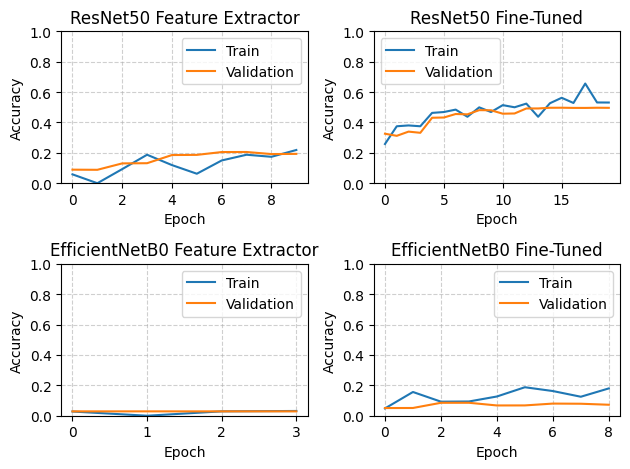

In [51]:

# ResNet50 Feature Extractor
plt.subplot(2, 2, 1)
plt.plot(history_fe.history['accuracy'], label='Train')
plt.plot(history_fe.history['val_accuracy'], label='Validation')
plt.title('ResNet50 Feature Extractor')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# ResNet50 Fine-Tuning
plt.subplot(2, 2, 2)
plt.plot(history_ft.history['accuracy'], label='Train')
plt.plot(history_ft.history['val_accuracy'], label='Validation')
plt.title('ResNet50 Fine-Tuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# EfficientNetB0 Feature Extractor
plt.subplot(2, 2, 3)
plt.plot(history_eff_fe.history['accuracy'], label='Train')
plt.plot(history_eff_fe.history['val_accuracy'], label='Validation')
plt.title('EfficientNetB0 Feature Extractor')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# EfficientNetB0 Fine-Tuning
plt.subplot(2, 2, 4)
plt.plot(history_eff_ft.history['accuracy'], label='Train')
plt.plot(history_eff_ft.history['val_accuracy'], label='Validation')
plt.title('EfficientNetB0 Fine-Tuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('all_models_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

#**Conclusions and Improvement Suggestions**

In [52]:
print("\n===== Conclusions and Improvement Suggestions =====\n")


===== Conclusions and Improvement Suggestions =====



In [53]:
# Get the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"BEST MODEL: {best_model_name}")
print(f"Best Accuracy: {best_model_accuracy:.4f}")

# General conclusions about the approaches
print("\nKey Findings:")

# Analyze feature extraction vs fine-tuning
fe_models = [m for m in results.keys() if 'FeatureExtractor' in m]
ft_models = [m for m in results.keys() if 'FineTuned' in m]
avg_fe_acc = sum(results[m]['accuracy'] for m in fe_models) / len(fe_models)
avg_ft_acc = sum(results[m]['accuracy'] for m in ft_models) / len(ft_models)

if avg_ft_acc > avg_fe_acc:
    print(f"1. Fine-tuning was more effective than feature extraction (avg: {avg_ft_acc:.4f} vs {avg_fe_acc:.4f})")
else:
    print(f"1. Feature extraction was more effective than fine-tuning (avg: {avg_fe_acc:.4f} vs {avg_ft_acc:.4f})")

# Compare architectures
resnet_models = [m for m in results.keys() if 'ResNet50' in m]
eff_models = [m for m in results.keys() if 'EfficientNetB0' in m]
avg_resnet_acc = sum(results[m]['accuracy'] for m in resnet_models) / len(resnet_models)
avg_eff_acc = sum(results[m]['accuracy'] for m in eff_models) / len(eff_models)

if avg_resnet_acc > avg_eff_acc:
    print(f"2. ResNet50 outperformed EfficientNetB0 (avg: {avg_resnet_acc:.4f} vs {avg_eff_acc:.4f})")
else:
    print(f"2. EfficientNetB0 outperformed ResNet50 (avg: {avg_eff_acc:.4f} vs {avg_resnet_acc:.4f})")

# Check for overfitting
overfitting_threshold = 0.05  # 5% gap between train and validation
models_with_overfitting = []

for model_name in results.keys():
    if 'ResNet50_FeatureExtractor' in model_name:
        hist = history_fe.history
    elif 'ResNet50_FineTuned' in model_name:
        hist = history_ft.history
    elif 'EfficientNetB0_FeatureExtractor' in model_name:
        hist = history_eff_fe.history
    else:
        hist = history_eff_ft.history

    train_acc = hist['accuracy'][-1]
    val_acc = hist['val_accuracy'][-1]

    if train_acc - val_acc > overfitting_threshold:
        models_with_overfitting.append((model_name, train_acc - val_acc))

if models_with_overfitting:
    print(f"3. Overfitting detected in {len(models_with_overfitting)} models:")
    for model, gap in models_with_overfitting:
        print(f"   - {model}: {gap:.4f} gap between train and validation accuracy")
else:
    print("3. No significant overfitting detected in any model")



BEST MODEL: ResNet50_FineTuned
Best Accuracy: 0.4972

Key Findings:
1. Fine-tuning was more effective than feature extraction (avg: 0.2913 vs 0.1172)
2. ResNet50 outperformed EfficientNetB0 (avg: 0.3514 vs 0.0571)
3. Overfitting detected in 1 models:
   - EfficientNetB0_FineTuned: 0.1076 gap between train and validation accuracy


In [54]:
# Suggestions for improvement
print("\nSuggestions for Improvement:")
print("1. Data Augmentation:")
print("   - Use more aggressive augmentation for challenging classes")
print("   - Consider class-specific augmentation strategies")

print("\n2. Architecture Modifications:")
print("   - Try different backbone architectures (e.g., Vision Transformer, DenseNet)")
print("   - Experiment with custom head architectures")
print("   - Use ensemble methods combining multiple models")

print("\n3. Training Strategies:")
print("   - Implement progressive fine-tuning (gradually unfreeze more layers)")
print("   - Use learning rate warmup and more sophisticated scheduling")
print("   - Implement class weighting to address imbalance")

print("\n4. Advanced Techniques:")
print("   - Test self-supervised pre-training on plant images")
print("   - Implement knowledge distillation for smaller deployment models")
print("   - Try semi-supervised approaches with pseudo-labeling")



Suggestions for Improvement:
1. Data Augmentation:
   - Use more aggressive augmentation for challenging classes
   - Consider class-specific augmentation strategies

2. Architecture Modifications:
   - Try different backbone architectures (e.g., Vision Transformer, DenseNet)
   - Experiment with custom head architectures
   - Use ensemble methods combining multiple models

3. Training Strategies:
   - Implement progressive fine-tuning (gradually unfreeze more layers)
   - Use learning rate warmup and more sophisticated scheduling
   - Implement class weighting to address imbalance

4. Advanced Techniques:
   - Test self-supervised pre-training on plant images
   - Implement knowledge distillation for smaller deployment models
   - Try semi-supervised approaches with pseudo-labeling


In [55]:

# Final thoughts
print("\nFinal Thoughts:")
if best_model_accuracy > 0.9:
    print("The models achieved excellent performance, suggesting the task is well-suited to transfer learning.")
elif best_model_accuracy > 0.8:
    print("The models achieved good performance, but there's room for improvement with the suggested techniques.")
else:
    print("The models achieved moderate performance, indicating this is a challenging task requiring more advanced techniques.")

print("\nThe GradCAM visualizations show that the models are mostly focusing on the relevant disease features,")
print("but improvements in localization could further enhance performance, especially for the challenging classes.")


Final Thoughts:
The models achieved moderate performance, indicating this is a challenging task requiring more advanced techniques.

The GradCAM visualizations show that the models are mostly focusing on the relevant disease features,
but improvements in localization could further enhance performance, especially for the challenging classes.
